In [2]:
%matplotlib widget
from labdata.schema import *
import pylab as plt


plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.matplotlib.rcParams['ps.fonttype'] = 42
savepath = Path('../../figures/figure4')
savepath.mkdir(parents = True,exist_ok = True)

KILOSORT_PARAMS_SET = 5
METRICS_PARAMS_SET = 1

procedures = ProbeInsertion() * Procedure() & 'procedure_type LIKE "chronic%"'
procedures = pd.DataFrame(procedures.fetch('probe_id', 'subject_name', 'procedure_datetime','procedure_type', order_by='procedure_datetime desc', as_dict=True)).drop_duplicates()
procedures = procedures[::]
first_implant = procedures.procedure_datetime.min()

# sort probe ids by their first implant
implants = procedures[procedures.procedure_type == 'chronic implant']
first_implants = implants.groupby('probe_id')['procedure_datetime'].min().reset_index()
sorted_prbs = first_implants.sort_values('procedure_datetime', ascending=False).probe_id.values

[2024-06-03 03:37:14,038][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:16,167][INFO]: Connected admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [3]:
sorted_prbs = ['22420006863',
               '22420007284',  
               '22420007982', 
               '22420007912',
               '22420006801',
               '22420007684',
               '22420007691',
               '22420007301',
               '22420007362', 
               '22420007231',
               '22420007032',
               '20403317093',
               '20403317493',
               '20403312592',
               '20097916762',
               '20097916141',
               '20403314292',
               '20403312442',
               '20403312213',
               '20403312751',
               '20403312621',
               '20403312753',
               '20097916222',
               '20097916182',
               '19454421152',
               '20097902741',
               '20097902851',
               ]
probe_labels = []
for p in sorted_prbs:
    probe_type = (Probe() & f'probe_id = "{p}"').fetch('probe_type')[0]
    if probe_type == '2013': # this requires latex to be installed
        pt = r'$\bf{NP2}$ '
    elif probe_type == '24':
        pt = r'$\bf{NP2a}$ '
    else:
        pt = r'$\bf{NP1}$ '
    probe_labels.append(pt+f'x{p[-4:]}')

In [4]:
UnitCount.populate(display_progress=True,processes = 4)

Processes:   0%|                                                                                                                                                                                            | 0/84 [00:00<?, ?it/s][2024-06-03 03:37:40,023][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:40,023][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:40,023][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:40,023][INFO]: Connecting admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:41,911][INFO]: Connected admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:41,911][INFO]: Connected admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-03 03:37:41,911][INFO]: Connected admin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.c

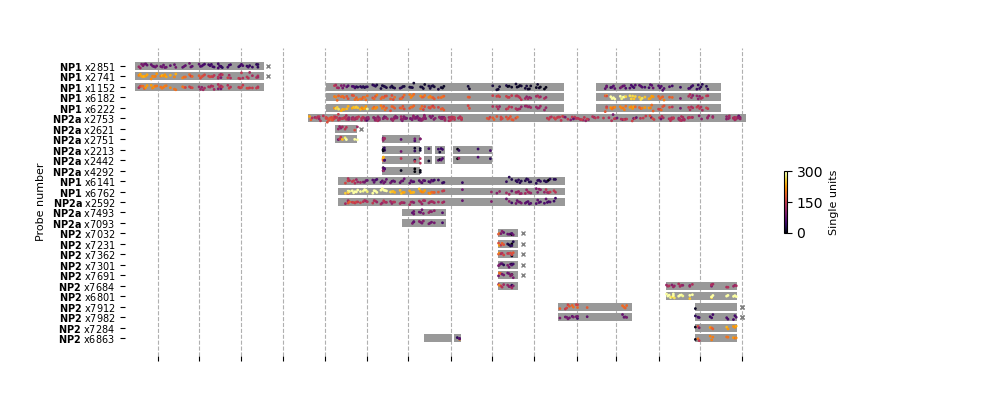

In [45]:
from datetime import timedelta
clims=(0,300)
bar_height = .9
bar_distance = 1.2

fig, ax = plt.subplots(figsize=(10,4))
prbs, heights = [], []
num_sessions = []
use_yscale = False
for prb_ind,prb in enumerate(sorted_prbs):
    implant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic implant')].procedure_datetime.values
    explants = pd.DataFrame((Procedure*ProbeExtraction() & f'probe_id = "{prb}"').fetch())
    explant_times = explants.procedure_datetime.values
    height = prb_ind*bar_distance
    for implant in implant_times:
        valid_explants = explant_times[explant_times > implant]
        if len(valid_explants) == 0:
            explant = np.datetime64(datetime.now()+timedelta(days=1))
        else:
            explant = valid_explants[np.argmin(valid_explants - implant)]
        plt.barh([height], np.array(explant-implant), left=[implant], height=bar_height, 
                 color='#999999', edgecolor='none',alpha=1,clip_on = False)
        for ie,e in explants.iterrows():
            if e.extraction_successful == 0:
                plt.plot(e.procedure_datetime + timedelta(days = 3),height,'x',markeredgecolor = 'gray',markersize = 3, clip_on = False)
        
    prbs.append(prb)
    heights.append(height)

    #get number of single units for a probe
    units_query = Session() * UnitCount() * EphysRecording.ProbeSetting() & dict(probe_id=prb,
                                                                                 unit_criteria_id=METRICS_PARAMS_SET,
                                                                                 parameter_set_num=KILOSORT_PARAMS_SET)
    recording_dates, num_single_units = units_query.fetch('session_datetime','sua')
    num_sessions.append(len(num_single_units))
    offset = np.random.normal(0, 0.15, len(recording_dates))
    offset = np.clip(offset, -bar_height/2, bar_height/2)
    #offset = np.random.uniform(-bar_height/2, bar_height/2, len(recording_dates))
    if use_yscale:
        y = np.array(num_single_units)
        y = y - np.min(y)
        y = y / np.max(y)
    
        scat = plt.scatter(recording_dates, y*0.6 + 0.1 +prb_ind*bar_distance-bar_height/2, 
                          s=1, c=np.array(num_single_units), clim=clims, cmap='inferno', alpha=1,clip_on = False)
    else:
        scat = plt.scatter(recording_dates, offset + prb_ind*bar_distance, 
                           s=1, c=np.array(num_single_units), clim=clims, cmap='inferno', alpha=1,clip_on = False)


plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
date_format = plt.matplotlib.dates.DateFormatter('') # %b-%Y
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.grid(which='major', axis='x', linestyle='--')
ax.set_axisbelow(True)
plt.ylabel('Probe number',fontsize = 8)
# plt.xlabel('Month',fontsize = 8)
from datetime import timedelta
start = first_implants.iloc[0].procedure_datetime
plt.xlim([start - timedelta(days=7),datetime.now()])
plt.yticks(heights, probe_labels); # label probes
# plt.xticks(rotation=-45);
plt.plot([start + timedelta(weeks = 4), start + timedelta(weeks = 4)],[10,10] )
cbar = plt.colorbar(scat,shrink = 0.2,ticks = [0,150,300])
cbar.solids.set_edgecolor("face")
cbar.set_label('Single units',fontsize = 8)
plt.gca().spines[['right', 'top', 'left','bottom']].set_visible(False)

if use_yscale:
    fig.savefig(savepath/f'recording_summary_yscaled.pdf')
else:
    fig.savefig(savepath/f'recording_summary.pdf')

In [46]:
(num_sessions)

[15,
 11,
 26,
 16,
 24,
 33,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 75,
 77,
 74,
 12,
 22,
 21,
 20,
 8,
 294,
 124,
 124,
 180,
 56,
 56]